In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3),
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
import math
def cosine_decay(epoch, total_epochs=200, initial_lr=0.01, min_lr=1e-6):
    cosine_decay_val = 0.5 * (1 + math.cos(math.pi * epoch / total_epochs))
    decayed_lr = (initial_lr - min_lr) * cosine_decay_val + min_lr
    return decayed_lr

initial_learning_rate = 0.001
lr_scheduler_callback = LearningRateScheduler(
    lambda epoch: cosine_decay(epoch, total_epochs=150, initial_lr=initial_learning_rate, min_lr=1e-7)
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, verbose=1),
    lr_scheduler_callback
]

In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)


history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=100,
                    validation_data=(test_images, test_labels),
                    callbacks=callbacks)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.2862 - loss: 2.3345 - val_accuracy: 0.4193 - val_loss: 1.8247 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.4572 - loss: 1.6297 - val_accuracy: 0.4763 - val_loss: 1.7550 - learning_rate: 9.9989e-04
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.5409 - loss: 1.4325 - val_accuracy: 0.5873 - val_loss: 1.3620 - learning_rate: 9.9956e-04
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.5860 - loss: 1.3330 - val_accuracy: 0.6586 - val_loss: 1.1537 - learning_rate: 9.9901e-04
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6302 - loss: 1.2494 - val_accuracy: 0.6411 - val_loss: 1.2502 - learning_rate: 9.9825e-04
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.6573 - loss: 1.1748 - val_accuracy: 0.6577 - val_loss: 1.1950 - learning_rate: 9.9726e-04
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accur

In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"\n Test Accuracy: {test_acc:.4f}")


 Test Accuracy: 0.8719


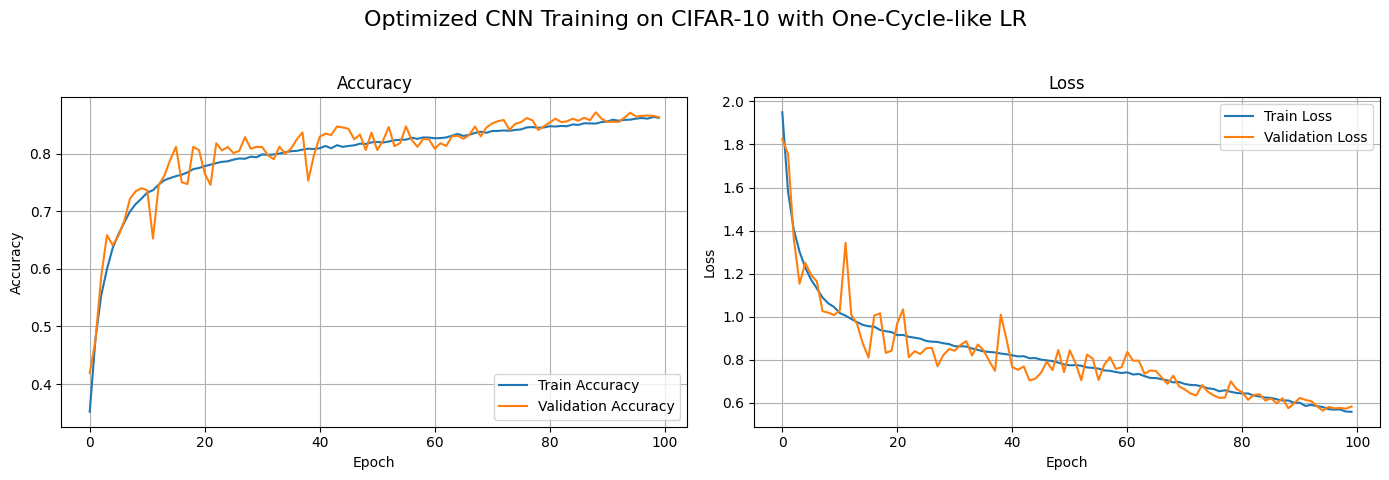

In [8]:
def plot_history(history, title):
    plt.figure(figsize=(14, 5))
    plt.suptitle(title, fontsize=16)

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    if 'lr' in history.history:
        ax2 = plt.gca().twinx()
        ax2.plot(history.history['lr'], color='orange', label='Learning Rate', linestyle=':')
        ax2.set_ylabel('Learning Rate', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        lines, labels = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='lower right')
    else:
        plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)

    # Plot Lossx
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_history(history, "Optimized CNN Training on CIFAR-10 with One-Cycle-like LR")

Comparison of this model with transfer learning on ResNet model for the same datatset (cifar10) is done in the **"Resnet_cifar10_HW.ipynb"** file